In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [2]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [3]:
word2vec = {}
with open(os.path.join('./data/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print("Found %s word vectors" % len(word2vec))

Found 400000 word vectors


In [4]:
train = pd.read_csv('./data/train.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [6]:
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

In [7]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [8]:
print("max sequence length", max(len(s) for s in sequences))
print("min sequence length", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length", s[len(s) // 2])

max sequence length 1400
min sequence length 0
median sequence length 35


In [9]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print("Unique tokens", len(word2idx))

Unique tokens 210337


In [10]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print(data.shape)

(159571, 100)


In [11]:
# prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros
            embedding_matrix[i] = embedding_vector

In [12]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

In [13]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)
r = model.fit(
    data, targets, batch_size=BATCH_SIZE, epochs=EPOCHS, 
    validation_split=VALIDATION_SPLIT
)

Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 5s 39us/step - loss: 0.0836 - acc: 0.9735 - val_loss: 0.0703 - val_acc: 0.9767
Epoch 2/10
127656/127656 [==============================] - 4s 31us/step - loss: 0.0677 - acc: 0.9772 - val_loss: 0.0745 - val_acc: 0.9765
Epoch 3/10
127656/127656 [==============================] - 4s 31us/step - loss: 0.0629 - acc: 0.9785 - val_loss: 0.0677 - val_acc: 0.9772
Epoch 4/10
127656/127656 [==============================] - 4s 31us/step - loss: 0.0597 - acc: 0.9792 - val_loss: 0.0880 - val_acc: 0.9703
Epoch 5/10
127656/127656 [==============================] - 4s 31us/step - loss: 0.0574 - acc: 0.9799 - val_loss: 0.0679 - val_acc: 0.9773
Epoch 6/10
127656/127656 [==============================] - 4s 31us/step - loss: 0.0553 - acc: 0.9804 - val_loss: 0.0690 - val_acc: 0.9767
Epoch 7/10
127656/127656 [==============================] - 4s 32us/step - loss: 0.0537 - acc: 0.9809 - val_loss: 0

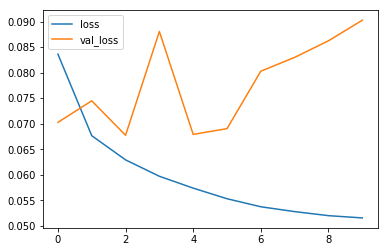

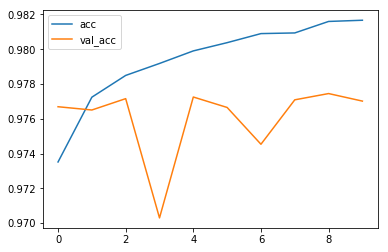

In [14]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [15]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9729619828033794
